In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.gridspec as gridspec
import pandas as pd

Before implementing decision tree we will review important concept that are used in Decision tree algorithms will be explained in "Classification" and "Regression" folders.

<blockquote>
A big amount of information was gathered from:<br>
    ELEMENTS OF INFORMATIONS THEORY<br>
    THOMAS M. COVER | JOY A. THOMAS
</blockquote>

In [2]:
# this module contains functions that were created by me 
# and spreadly used in this notebook. To make this notebook
import funcs

import warnings 
warnings.filterwarnings('ignore')


## Entropy
### **[Q]** What is entropy? 

**[A]** Entropy is a measure that shows the degree of how much the data is uncertain. 
<blockquote>
    <p>It's one of possible interpretation of entropy</p>
</blockquote>

Formula:
$$H(X) = -\sum_xp(x)\log_2p(x)$$




### **[Q]** What means uncertain?

**[A]** If entropy is low data in certain, if high then the opposite. 
I will draw an example:
    ![entropy](img/entropy.png)
<br>

    

### **[Q]** Why do we need log and why we multiply $\log_2$ of $p(x)$ by $p(x)$? 



**[A]** The goal of this equation is to give hight values when data is uncertain and low values when the opposite. And a lot of function satisfy this propety, but information should be additive.

<blockquote>
    <p>"In other words if we see event X with probability p and event Y with probability q, and they occur independently, then we should have

I(pq) = I(p) + I(q)

where I(p) is the information associated with seeing an event with probability p, likewise q. The only function that satisfies this and the other properties we want it to have is the logarithm:

log(ab) = log(a) + log(b)"</p>
 <a href="https://www.reddit.com/user/gatherinfer">/u/gatherinfer</a> as a comment to <a href="https://www.reddit.com/r/statistics/comments/9t7mj3/intuition_of_basic_principles_of_information/">this</a> post
</blockquote>
<br> 


Let's consider 3 possible states of random variable: a,b,c then

+ If $p(a)\approx1$ then $\log_2p(a)\approx0$ (because 2^0=1) so the product $p(a)\log_2p(a)$ will be **infinitesimal**. If $p(a)\approx1$ then probability of other possible states ( $p(b)\ p(c)$ ) of the random variable will be very small too, so their products with log will be tiny<br>
+ If $p(a)\approx p(b)\approx p(c)$ then entropy will be a **relatively big number**. 

We will check that in an example below

### **[Q]** Why should we use base 2 for logarithm? 

Actually, you can use any number as a base for logarithm - it won't break the idea behind. In this notebook and in functions that are defined in funcs.py I use base 2. 
<blockquote>
    <p>
"... In computer science we usually use base-2 because of the natural connection to binary bits, but in statistical thermodynamics we use the natural logarithm (base-e) because it plays nicer with calculus (the units are called "nats" in analogy with "bits") ..." </p> 
    <a href="https://www.reddit.com/user/gatherinfer">/u/gatherinfer</a> as a comment to <a href="https://www.reddit.com/r/statistics/comments/9t7mj3/intuition_of_basic_principles_of_information/">this</a> post
</blockquote>


### **[Q]** Why there's a minus? 

**[A]** Because log with base 2 of probability returns negative values. That happens because p(x) < 2 and the exponent needs to be negative in order for 2 to get p(x). For example:
$$ \log_2(1/8) = -3 $$
because
$$ 2^{-3} = 1/8 $$
and we want the measure of entropy to be positive, because that have more common sense. 

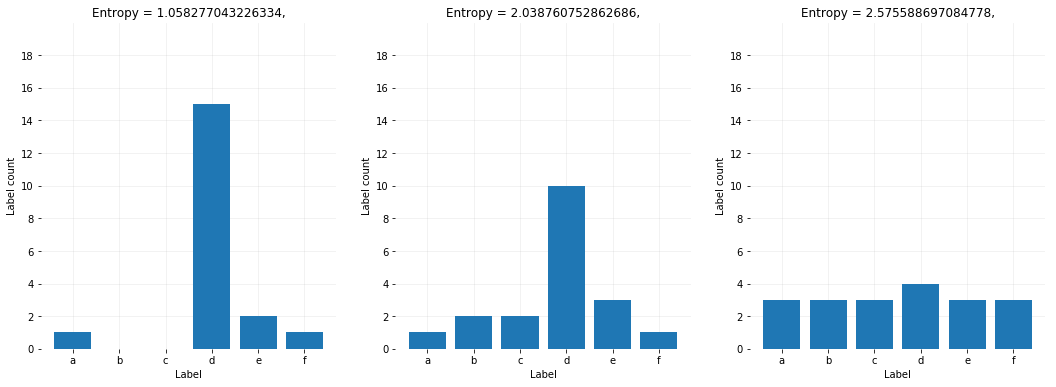

In [3]:
# every data have size  of 20
dicttd = np.array(['a','b','c','d','e','f'])

#test data
testd1 = np.array(['a', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'e', 'e', 'f'])
testd2 = np.array(['a', 'b', 'b', 'c', 'c', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd','e', 'e', 'e', 'f'])
testd3 = np.array(['a', 'a', 'a', 'b', 'b', 'b', 'c', 'c', 'c', 'd', 'd', 'd', 'd', 'e', 'e', 'e', 'f', 'f', 'f'])

#making array of test data
test_data = [testd1, testd2, testd3]
f, axes = plt.subplots(1,3,figsize=(18,6))

for indx, ax in enumerate(axes):
    data = test_data[indx]
    ax.grid(alpha=0.2)
    amount = np.array([])
    
    for l in dicttd:
        amount = np.append(amount,data[data==l].shape[0])

    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    ax.set_xlabel('Label')
    ax.set_ylabel('Label count')
    ax.set_ylim(0,20)
    ax.set_xticks(np.arange(0,len(dicttd)+1))
    ax.set_xticklabels(dicttd)
    ax.set_yticks(np.arange(0, test_data[indx].shape[0]+1, 2.0))
    ax.bar(dicttd,amount,zorder=100)
    ax.set_title('Entropy = {},'.format(funcs.Itheory.entropy(amount[amount.nonzero()]/data.shape[0])))

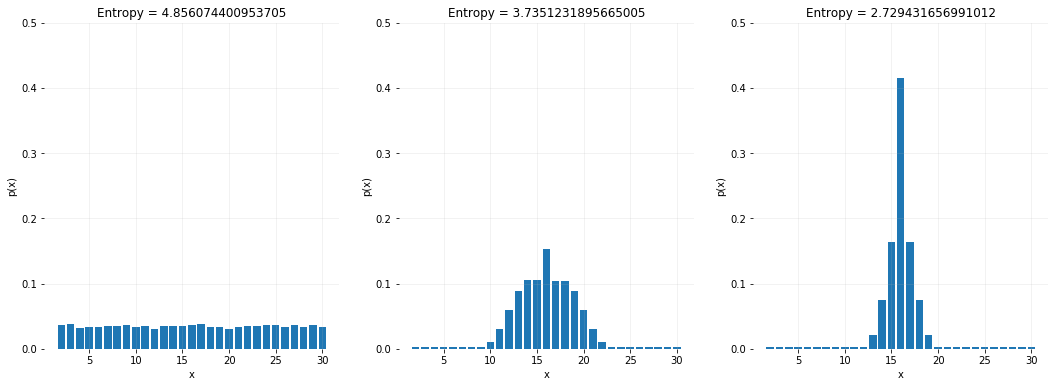

In [4]:
unif = np.ceil(np.random.uniform(low=1,high=30,size=10000)).astype('int')
f, axes = plt.subplots(1,3,figsize=(18,6))
unif_values, unif_dist = funcs.Probability.get_distr(unif)
for ax in axes:
    funcs.Utility.make_ax_look_good(ax)
    ax.bar(unif_values, unif_dist)
    ax.set_title('Entropy = {}'.format(funcs.Itheory.entropy(unif_dist)))
    unif_dist = funcs.Utility.less_ent(unif_dist, multiplier=0.6, steps=20, low_border=0.003)
    ax.set_ylim(0,0.5)
    ax.set_ylabel('p(x)')
    ax.set_xlabel('x')


As you can see when PMF approaches uniform distribution - entropy increases. 

## Data preparation section
Next section of code not necessary to look thoroughly. In the section I'm defining variables and creating patterns to be shown after. 

In [5]:
unif = np.ceil(np.random.uniform(low=1,high=35,size=5000)).astype('int')
#np.ceil(np.random.uniform(low=1,high=50,size=3000)).astype('int')
gamma = np.random.gamma(10,1,5000).round().astype('int')

chang_unif = funcs.Utility.shuffle_data(unif.copy(),chance=0.3,times=10)

v_unif = [
    funcs.Utility.shuffle_data(unif.copy(),chance=0.1,times=2,  count_low_boundary=15,count_max_boundary=500),
    funcs.Utility.shuffle_data(unif.copy(),chance=0.9,times=10, count_low_boundary=15, count_max_boundary=500),
    funcs.Utility.less_ent_d(unif.copy(),step_m = 2, low_boundary=4, times=4)
]


gamma_dict = set(np.unique(gamma))
unif_dict = set(np.unique(unif))
v1u = set(np.unique(v_unif[0]))
v2u = set(np.unique(v_unif[1]))
v3u = set(np.unique(v_unif[2]))

all_dict = gamma_dict.copy()
all_dict.update(unif_dict)
all_dict.update(v1u)
all_dict.update(v2u)
all_dict.update(v3u)


datas_cm = np.array([
    [unif, unif],
    [unif, v_unif[0]],
    [unif, v_unif[1]],
    [unif, v_unif[2]],
    [unif, gamma],
],)

i_information = np.array([

])

## Joint Entropy and Conditional entropy

### Joint Entropy 

By increasing distance between distributions joint entropy increases. 

Formula:
$$H(X,Y) =-\sum_{x\in X}\sum_{y\in Y}p(x,y)\log p(x,y)$$

**[Q] What you have meant by "distance"?**

**[A]** I would recommend to scroll down to section where I show Venn diagram. 

Joint entropy can vary 

_from_

__H(X) or H(Y)__ (when distributions is equal) 

_to_ 

__H(X) + H(Y)__ 

### Conditional Entropy 

Conditional entropy can take values between H(X) (when distributions are completely different) and 0 (when distribution is the same). 

_from_

__0__ (when distributions is equal) 

_to_ 

__H(X)__  


Formula:
\begin{split}
H(Y|X) & = \sum_{x\in X}p(x)H(Y|X = x) \\
 & = -\sum_{x\in X}\sum_{y\in Y}p(x,y)\log p(y|x)
\end{split}
      

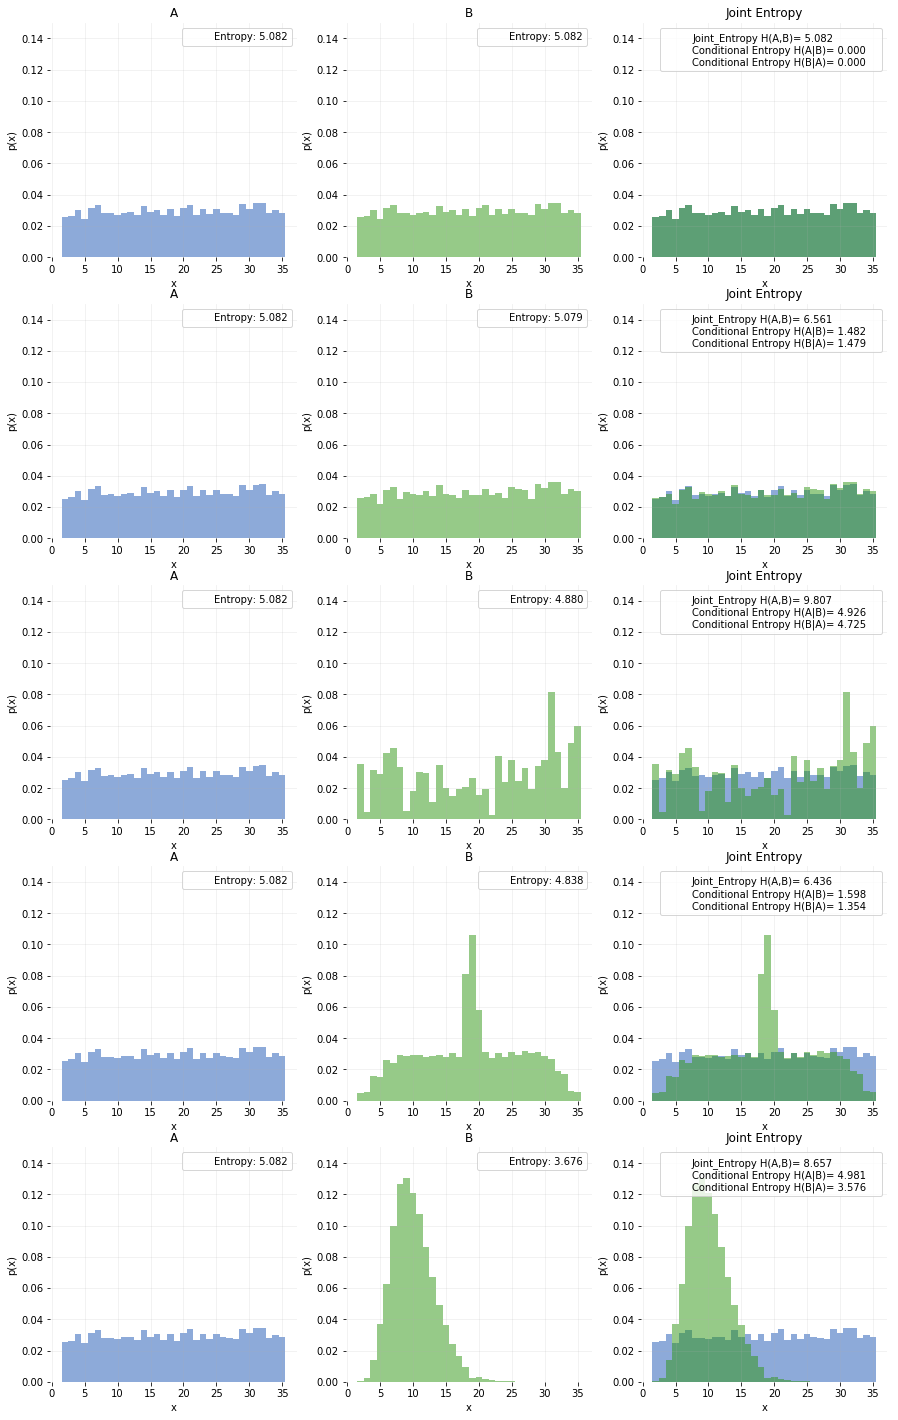

In [6]:
i_information = {}
texts = ['A', 'B', 'Joint Entropy'] # text that'll used in graphs
colors = ['#1c57b5','#2e9612'] # color for graphs

figure, axes = plt.subplots(datas_cm.shape[0],3,figsize=(15,5*datas_cm.shape[0]))
up_bound = 0.15

for indx_l, line in enumerate(axes): #inde_l - index line 
    ax_f, ax_s, ax_t = line[0],line[1],line[2]
    ax_fg = [ax_f, ax_s]
    
    f_d = funcs.Probability.get_distr(datas_cm[indx_l, 0],all_dict)[1]
    s_d = funcs.Probability.get_distr(datas_cm[indx_l, 1],all_dict)[1]
    
    e_f = funcs.Itheory.entropy(f_d)
    e_s = funcs.Itheory.entropy(s_d)
    
    extra = mlp.patches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    
    for indx_e,[ax,dat,ent] in enumerate(list(zip([ax_f,ax_s],[f_d,s_d],[e_f,e_s]))):
        ax.bar(list(all_dict), dat, width=1, alpha = 0.5, facecolor=colors[indx_e])
        ax.legend([extra],('Entropy: {:.3f}'.format(ent),))
    
    ax_t.bar(list(all_dict), f_d, width=1, alpha = 0.5, facecolor=colors[0])
    ax_t.bar(list(all_dict), s_d, width=1, alpha = 0.5, facecolor=colors[1])
    
    table = funcs.Probability.dist_table(datas_cm[indx_l, 0], datas_cm[indx_l, 1])[2]
    j_e = funcs.Itheory.joint_entropy(table)
    cond_ab = funcs.Itheory.conditional_entropy(table,axis_marginal=0)
    cond_ba = funcs.Itheory.conditional_entropy(table,axis_marginal=1)
    
    ax_t.set_title(texts[2])
    
    ax_t.legend([extra],('Joint_Entropy H(A,B)= {0:.3f}\nConditional Entropy H(A|B)= {1:.3f}\
    \nConditional Entropy H(B|A)= {2:.3f}'.format(j_e, cond_ab, cond_ba),))

    i_information[indx_l]=[e_f, e_s, j_e, cond_ab, cond_ba]

    for indx_e, ax in enumerate(line):
        ax.set_title(texts[indx_e])
        funcs.Utility.make_ax_look_good(ax)
        ax.set_ybound(lower=0.0, upper=up_bound)
        ax.set_xlabel('x')
        ax.set_ylabel('p(x)')


## Relative Entropy
<blockquote>
    <p>Also, being referred as: Kullback–Leibler distance
</blockquote>

### [Q] What is relative entropy?

[A] Relative entropy is a measure of how "not right" an assumption that the distribution is q when the true distribution is p. 

Formula: 

$$ D(p||q) = \sum_{x\in X}p(x)\log \frac{p(x)}{q(x)} $$

q — an assumption
p — true distribution

### [Q] Why in the last graph relative entropy is infinite?
[A] Because, by the convention, if q(x)=0 and p(x)>0 then we assign infinity. This shows that the error of assumption is infinite and q(x) cannot be the distribution when the true distribution is p. 

### [Q] If you would look on the graph what is the pattern? 
[A] When distribution's resemblance with pair decreases - the relative entropy grows. So for first graph relative entropy is equal to 0 because A and B have same probability of each element to occur. 

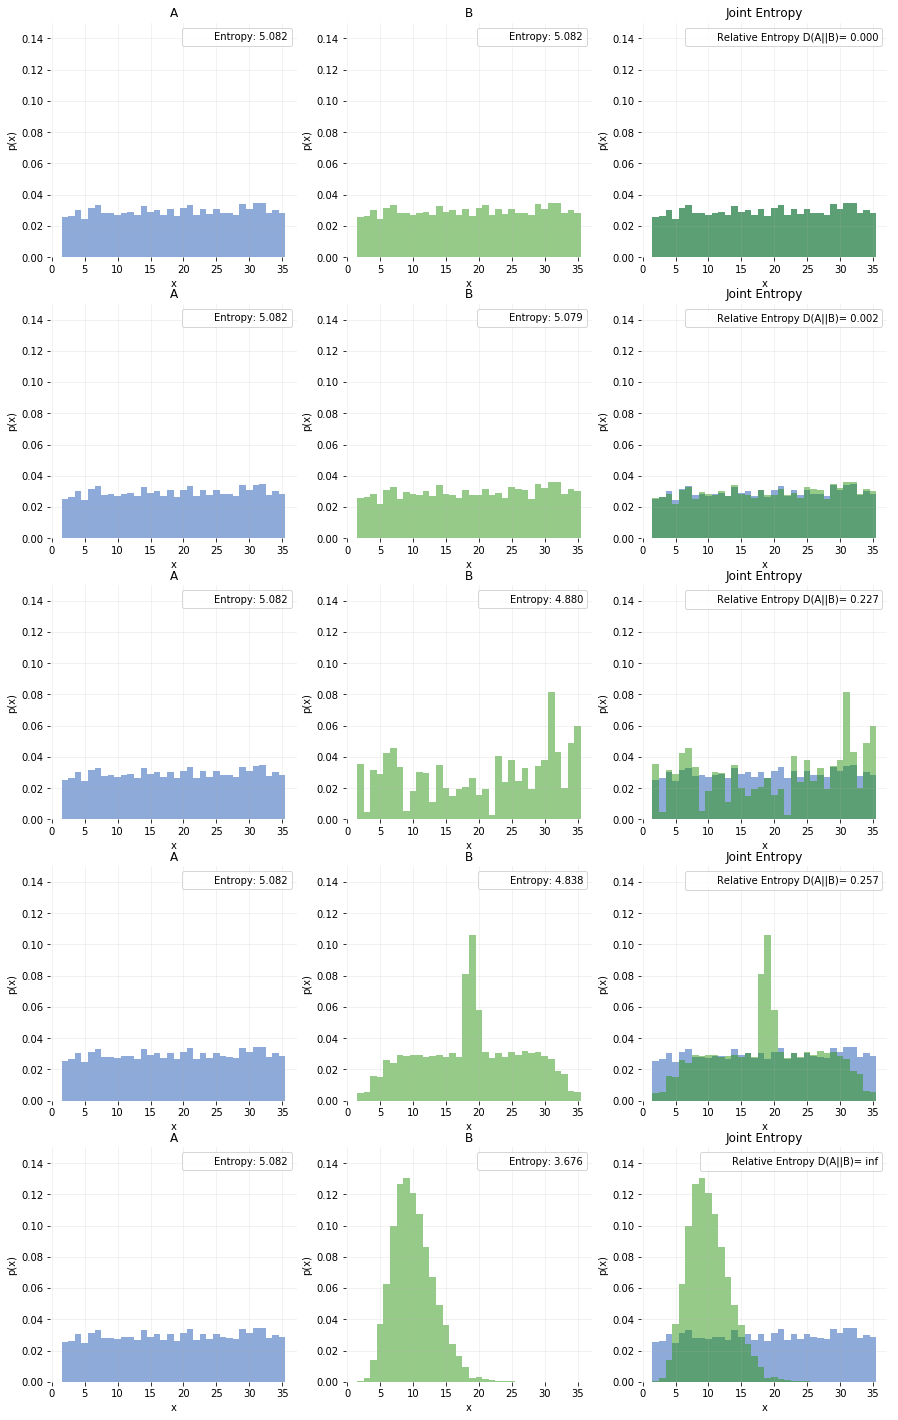

In [7]:
texts = ['A', 'B', 'Joint Entropy']
figure, axes = plt.subplots(datas_cm.shape[0],3,figsize=(15,5*datas_cm.shape[0]))
up_bound = 0.15

for indx_l, line in enumerate(axes): #inde_l - index line 
    ax_f, ax_s, ax_t = line[0],line[1],line[2]
    ax_fg = [ax_f, ax_s]
    
    f_d = funcs.Probability.get_distr(datas_cm[indx_l, 0],all_dict)[1]
    s_d = funcs.Probability.get_distr(datas_cm[indx_l, 1],all_dict)[1]
    
    extra = mlp.patches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    for indx_e,[ax,dat] in enumerate(list(zip([ax_f,ax_s],[f_d,s_d]))):
        ax.bar(list(all_dict), dat, width=1, alpha = 0.5, facecolor=colors[indx_e])
        ax.legend([extra],('Entropy: {:.3f}'.format(funcs.Itheory.entropy(dat)),))
    
    ax_t.bar(list(all_dict), f_d, width=1, alpha = 0.5, facecolor=colors[0])
    ax_t.bar(list(all_dict), s_d, width=1, alpha = 0.5, facecolor=colors[1])
    
    rel_e = funcs.Itheory.rel_entropy(f_d, s_d)
    
    table = funcs.Probability.dist_table(datas_cm[indx_l, 0], datas_cm[indx_l, 1])[2]
    ax_t.set_title(texts[2])
    ax_t.legend([extra],('Relative Entropy D(A||B)= {0:.3f}'.format(rel_e),))
    
    i_information[indx_l].append(rel_e)
    for indx_e, ax in enumerate(line):
        ax.set_title(texts[indx_e])
        funcs.Utility.make_ax_look_good(ax)
        ax.set_ybound(lower=0.0, upper=up_bound)
        ax.set_xlabel('x')
        ax.set_ylabel('p(x)')


## Mutual Information


### [Q] What is "mutual information"?
It's a measure of how much information about one distribution contains in another. 



\begin{split}
I(X; Y) & = \sum_{x\in X}\sum_{y\in Y}p(x,y)\log\frac{p(x,y)}{p(x)p(y)} \\
 & = D(p(x,y)||p(x)p(y))
\end{split}

<blockquote>
    <p>
        $p(x,y)=p(x)p(y|x)$<br>
        $p(y|x) = \frac{p(x,y)}{p(x)}$
    </p>
</blockquote>

### [Q] If you would look on the graphs what is the pattern? 
[A] As distribution 'A' approaches distribution 'B' mutual information increases till it'll be equal to the entropy of A and B (It will happen when distribution is the same). 

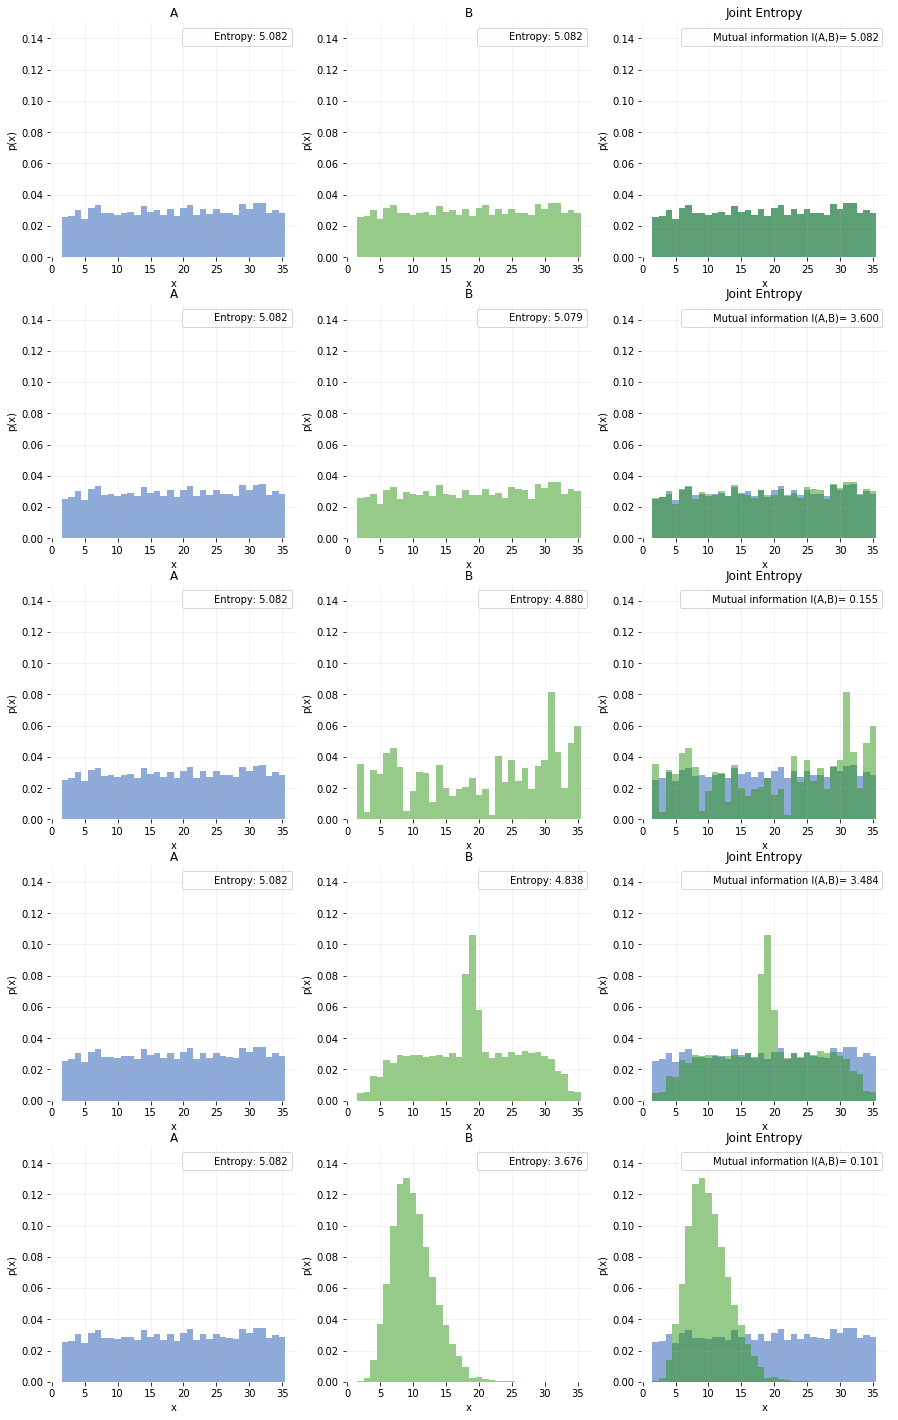

In [8]:
texts = ['A', 'B', 'Joint Entropy']
figure, axes = plt.subplots(datas_cm.shape[0],3,figsize=(15,5*datas_cm.shape[0]))
up_bound = 0.15

for indx_l, line in enumerate(axes): #inde_l - index line 
    ax_f, ax_s, ax_t = line[0],line[1],line[2]
    ax_fg = [ax_f, ax_s]
    
    f_d = funcs.Probability.get_distr(datas_cm[indx_l, 0],all_dict)[1]
    s_d = funcs.Probability.get_distr(datas_cm[indx_l, 1],all_dict)[1]
    f_dwd = funcs.Probability.get_distr(datas_cm[indx_l, 0])[1]
    s_dwd = funcs.Probability.get_distr(datas_cm[indx_l, 1])[1]
    
    extra = mlp.patches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    for indx_e,[ax,dat] in enumerate(list(zip([ax_f,ax_s],[f_d,s_d]))):
        ax.bar(list(all_dict), dat, width=1, alpha = 0.5, facecolor=colors[indx_e])
        ax.legend([extra],('Entropy: {:.3f}'.format(funcs.Itheory.entropy(dat)),))
    
    ax_t.bar(list(all_dict), f_d, width=1, alpha = 0.5, facecolor=colors[0])
    ax_t.bar(list(all_dict), s_d, width=1, alpha = 0.5, facecolor=colors[1])
    
    table = funcs.Probability.dist_table(datas_cm[indx_l, 0], datas_cm[indx_l, 1])[2]
    ax_t.set_title(texts[2])
    
    mut_inf = funcs.Itheory.mutual_information(f_dwd,s_dwd,table)
    ax_t.legend([extra],('Mutual information I(A,B)= {0:.3f}'.format(mut_inf),))
    
    i_information[indx_l].append(mut_inf)
    
    for indx_e, ax in enumerate(line):
        ax.set_title(texts[indx_e])
        funcs.Utility.make_ax_look_good(ax)
        ax.set_ybound(lower=0.0, upper=up_bound)
        ax.set_xlabel('x')
        ax.set_ylabel('p(x)')

## Connection between concepts. 

In the book "ELEMENTS OF INFORMATIONS THEORY. THOMAS M. COVER | JOY A. THOMAS" you would find a great Venn diagram and in inspiration of the diagram I have created another one which resembles the former. 
![venn_diag](img/venn_dia.png)

If I were to explain in sql then:

$H(A|B)$ - left join

$H(B|A)$ - right join

$I(X;Y)$ - inner join

$H(X,Y)$ - join 


For me it is convenient to think of these concept with a picture in mind of the diagram. Imagine how I(X,Y) changes when distribution have more in common (imagine as the circles starting to cover each other more and more). 

## Testing properties of Joint Entropy, Conditional Entropy and Mutual Information.

To be sure in whether the function for calculating variables right or not, I will test properties of the variables such that:

\begin{split}
1.\ &I(X,Y)\ & = H(X) - H(X|Y) \\
2.\ &I(X,Y)\ & = H(X) + H(Y) - H(X,Y)\\
3.\ &H(X,Y)\ & = H(X) + H(Y|X)
\end{split}

I'll use generated data that was used in the graphs above. 

<blockquote>
I will round data to 5 digits to exclude floating point problem

https://docs.python.org/3.7/tutorial/floatingpoint.html

https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
</blockquote>

In [9]:
info = pd.DataFrame(i_information).transpose()
info.columns=['H(A)','H(B)','H(A,B)','H(A|B)',\
              'H(B|A)','D(A||B)','I(A,B)']
info=info.round(5)
pd.options.display.float_format = '{:.5f}'.format
info

,H(A),H(B),"H(A,B)",H(A|B),H(B|A),D(A||B),"I(A,B)"
0,5.08176,5.08176,5.08176,0.00000,0.00000,0.00000,5.08176
1,5.08176,5.07863,6.56066,1.48203,1.47890,0.00240,3.59973
2,5.08176,4.88044,9.80676,4.92632,4.72500,0.22716,0.15544
3,5.08176,4.83819,6.43584,1.59765,1.35409,0.25743,3.48410
4,5.08176,3.67631,8.65736,4.98105,3.57561,inf,0.10071


In [10]:
def test(x):
    print('='*4,'Test func output','='*4)
    print('1: ',x.loc['I(A,B)'],' = ',np.round(x.loc['H(A)']-x.loc['H(A|B)'],5))
    print('2: ',x.loc['I(A,B)'],' = ',np.round(x.loc['H(A)']+x.loc['H(B)']-x.loc['H(A,B)'],5))
    print('3: ',x.loc['H(A,B)'],' = ',np.round(x.loc['H(A)']+x.loc['H(B|A)'],5))
    print('='*26,'\n')
info.apply(test,axis=1);

==== Test func output ====
1:  5.08176  =  5.08176
2:  5.08176  =  5.08176
3:  5.08176  =  5.08176

==== Test func output ====
1:  3.59973  =  3.59973
2:  3.59973  =  3.59973
3:  6.56066  =  6.56066

==== Test func output ====
1:  0.15544  =  0.15544
2:  0.15544  =  0.15544
3:  9.80676  =  9.80676

==== Test func output ====
1:  3.4841  =  3.48411
2:  3.4841  =  3.48411
3:  6.43584  =  6.43585

==== Test func output ====
1:  0.10071  =  0.10071
2:  0.10071  =  0.10071
3:  8.65736  =  8.65737

